In [1]:
#DataFlair Project
#import all the required libraries
import numpy as np
import pandas as pd
import pickle
from statistics import mode
import nltk
from nltk import word_tokenize
from nltk.stem import LancasterStemmer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,Attention
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nekka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nekka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nekka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
#read the dataset file for text Summarizer
df=pd.read_csv(r"C:\Users\nekka\Downloads\Reviews.csv",nrows=100000)
#drop the duplicate and na values from the records
df.drop_duplicates(subset=['Text'],inplace=True)
df.dropna(axis=0,inplace=True)
input_data = df.loc[:,'Text']
target_data = df.loc[:,'Summary']
target_data.replace('', np.nan, inplace=True)

In [5]:
input_texts=[]
target_texts=[]
input_words=[]
target_words=[]
contractions=pickle.load(open("contractions.pkl","rb"))['contractions']
#initialize stop words and LancasterStemmer
stop_words=set(stopwords.words('english'))
stemm=LancasterStemmer()

In [6]:
def clean(texts,src):
  #remove the html tags
  texts = BeautifulSoup(texts, "lxml").text
  #tokenize the text into words 
  words=word_tokenize(texts.lower())
  #filter words which contains \ 
  #integers or their length is less than or equal to 3
  words= list(filter(lambda w:(w.isalpha() and len(w)>=3),words))
  #contraction file to expand shortened words
  words= [contractions[w] if w in contractions else w for w in words ]
#stem the words to their root word and filter stop words
  if src=="inputs":
    words= [stemm.stem(w) for w in words if w not in stop_words]
  else:
    words= [w for w in words if w not in stop_words]
  return words

In [7]:
#pass the input records and taret records
for in_txt,tr_txt in zip(input_data,target_data):
  in_words= clean(in_txt,"inputs")
  input_texts+= [' '.join(in_words)]
  input_words+= in_words
  #add 'sos' at start and 'eos' at end of text
  tr_words= clean("sos "+tr_txt+" eos","target")
  target_texts+= [' '.join(tr_words)]
  target_words+= tr_words

d:\python\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [12]:
f = open("targetwords.txt", "w")
for i in target_words:
	f.write(i+"\n")
f.close()

In [8]:
input_words = sorted(list(set(input_words)))
target_words = sorted(list(set(target_words)))
num_in_words = len(input_words) #total number of input words
num_tr_words = len(target_words) #total number of target words
 
#get the length of the input and target texts which appears most often  
max_in_len = mode([len(i) for i in input_texts])
max_tr_len = mode([len(i) for i in target_texts])
 
print("number of input words : ",num_in_words)
print("number of target words : ",num_tr_words)
print("maximum input length : ",max_in_len)
print("maximum target length : ",max_tr_len)

number of input words :  32198
number of target words :  14171
maximum input length :  74
maximum target length :  17


In [9]:
#split the input and target text into 80:20 ratio or testing size of 20%.
x_train,x_test,y_train,y_test=train_test_split(input_texts,target_texts,test_size=0.2,random_state=0) 

In [10]:
#train the tokenizer with all the words
in_tokenizer = Tokenizer()
in_tokenizer.fit_on_texts(x_train)
tr_tokenizer = Tokenizer()
tr_tokenizer.fit_on_texts(y_train)
 
#convert text into sequence of integers
#where the integer will be the index of that word
x_train= in_tokenizer.texts_to_sequences(x_train) 
y_train= tr_tokenizer.texts_to_sequences(y_train)

In [13]:
#pad array of 0's if the length is less than the maximum length 
en_in_data= pad_sequences(x_train,  maxlen=max_in_len, padding='post') 
dec_data= pad_sequences(y_train,  maxlen=max_tr_len, padding='post')
 
#decoder input data will not include the last word 
#i.e. 'eos' in decoder input data
dec_in_data = dec_data[:,:-1]
#decoder target data will be one time step ahead as it will not include
# the first word i.e 'sos'
dec_tr_data = dec_data.reshape(len(dec_data),max_tr_len,1)[:,1:]

In [14]:
K.clear_session() 
latent_dim = 500
 
#create input object of total number of encoder words
en_inputs = Input(shape=(max_in_len,)) 
en_embedding = Embedding(num_in_words+1, latent_dim)(en_inputs) 

In [15]:
#create 3 stacked LSTM layer with the shape of hidden dimension for text summarizer using deep learning
#LSTM 1
en_lstm1= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_outputs1, state_h1, state_c1= en_lstm1(en_embedding) 
 
#LSTM2
en_lstm2= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_outputs2, state_h2, state_c2= en_lstm2(en_outputs1) 
 
#LSTM3
en_lstm3= LSTM(latent_dim,return_sequences=True,return_state=True)
en_outputs3 , state_h3 , state_c3= en_lstm3(en_outputs2)
 
#encoder states
en_states= [state_h3, state_c3]

In [16]:
# Decoder. 
dec_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(num_tr_words+1, latent_dim) 
dec_embedding = dec_emb_layer(dec_inputs) 
 
#initialize decoder's LSTM layer with the output states of encoder
dec_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
dec_outputs, *_ = dec_lstm(dec_embedding,initial_state=en_states) 

In [17]:
#Attention layer
attention =Attention()
attn_out = attention([dec_outputs,en_outputs3])
 
#Concatenate the attention output with the decoder outputs
merge=Concatenate(axis=-1, name='concat_layer1')([dec_outputs,attn_out])

In [18]:
#Dense layer (output layer)
dec_dense = Dense(num_tr_words+1, activation='softmax') 
dec_outputs = dec_dense(merge) 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 74)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 74, 500)      16099500    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 74, 500),    2002000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

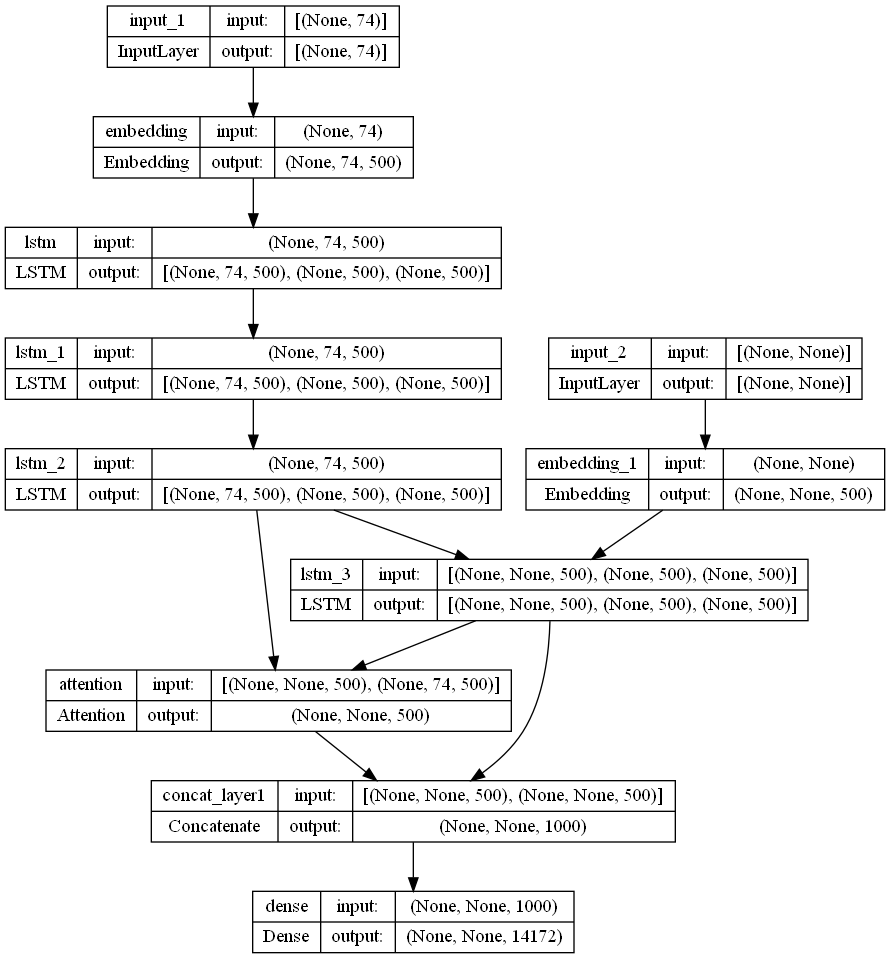

In [19]:
#Model class and model summary for text Summarizer
model = Model([en_inputs, dec_inputs], dec_outputs) 
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [39]:
model.compile( 
    optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"] ) 
model.fit( 
    [en_in_data, dec_in_data],
    dec_tr_data, 
    batch_size=512, 
    epochs=10, 
    validation_split=0.1,
    )
 
#Save model
model.save("s2s")

Epoch 1/10
  2/182 [..............................] - ETA: 1:19:13 - loss: 9.3452 - accuracy: 0.3833    


KeyboardInterrupt



In [2]:
# encoder inference
latent_dim=500
#/content/gdrive/MyDrive/Text Summarizer/
#load the model
model = models.load_model("s2s")
 
#construct encoder model from the output of 6 layer i.e.last LSTM layer
en_outputs,state_h_enc,state_c_enc = model.layers[6].output
en_states=[state_h_enc,state_c_enc]
#add input and state from the layer.
en_model = Model(model.input[0],[en_outputs]+en_states)

In [20]:
# decoder inference
#create Input object for hidden and cell state for decoder
#shape of layer with hidden or latent dimension
dec_state_input_h = Input(shape=(latent_dim,))
dec_state_input_c = Input(shape=(latent_dim,))
dec_hidden_state_input = Input(shape=(max_in_len,latent_dim))
 
# Get the embeddings and input layer from the model
dec_inputs = model.input[1]
dec_emb_layer = model.layers[5]
dec_lstm = model.layers[7]
dec_embedding= dec_emb_layer(dec_inputs)
 
#add input and initialize LSTM layer with encoder LSTM states.
dec_outputs2, state_h2, state_c2 = dec_lstm(dec_embedding, initial_state=[dec_state_input_h,dec_state_input_c])

In [21]:
#Attention layer
attention = model.layers[8]
attn_out2 = attention([dec_outputs2,dec_hidden_state_input])
 
merge2 = Concatenate(axis=-1)([dec_outputs2, attn_out2])

In [22]:
#Dense layer
dec_dense = model.layers[10]
dec_outputs2 = dec_dense(merge2)
 
# Finally define the Model Class
dec_model = Model(
[dec_inputs] + [dec_hidden_state_input,dec_state_input_h,dec_state_input_c],
[dec_outputs2] + [state_h2, state_c2])

In [23]:
#create a dictionary with a key as index and value as words.
reverse_target_word_index = tr_tokenizer.index_word
reverse_source_word_index = in_tokenizer.index_word
target_word_index = tr_tokenizer.word_index
reverse_target_word_index[0]=' '
 
def decode_sequence(input_seq):
    #get the encoder output and states by passing the input sequence
    en_out, en_h, en_c= en_model.predict(input_seq)
 
    #target sequence with initial word as 'sos'
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_word_index['sos']
 
    #if the iteration reaches the end of text than it will be stop the iteration
    stop_condition = False
    #append every predicted word in decoded sentence
    decoded_sentence = ""
    while not stop_condition: 
        #get predicted output, hidden and cell state.
        output_words, dec_h, dec_c= dec_model.predict([target_seq] + [en_out,en_h, en_c])
        
        #get the index and from the dictionary get the word for that index.
        word_index = np.argmax(output_words[0, -1, :])
        text_word = reverse_target_word_index[word_index]
        decoded_sentence += text_word +" "
        if text_word == "eos" or len(decoded_sentence) > max_tr_len:
           stop_condition = True
      #update target sequence to the current word index.
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = word_index
        en_h, en_c = dec_h, dec_c
  #return the decoded sentence
    return decoded_sentence

In [27]:
inp_review = input("Enter : ")
print("Review :",inp_review)
inp_review = clean(inp_review,"inputs")
inp_review = ' '.join(inp_review)
inp_x= in_tokenizer.texts_to_sequences([inp_review]) 
inp_x= pad_sequences(inp_x,  maxlen=max_in_len, padding='post')
 
summary=decode_sequence(inp_x.reshape(1,max_in_len))
if 'eos' in summary :
  summary=summary.replace('eos','')
print("\nPredicted summary:",summary);print("\n")

Review : My mom was surprised and she loved it. She was totally impressed with the features like Calling, Heart rate and so on. I kept a water reminder as it's summer and she loved it as it reminds her the whole day to drink water. I'm totally in love with this product. Thanks
1/1 [==============================] - 0s 38ms/step

Predicted summary: pedialyte pedialyte 


